# Phase 2A: Basic Text Feature Extraction (TF-IDF Baseline)

## Goals:
1. Extract TF-IDF features from clinical text
2. Create baseline text similarity search
3. Evaluate performance
4. Save features for later comparison

## Why Start with TF-IDF?
- **Fast to implement** (30 minutes)
- **Good baseline** to compare against deep learning
- **Easy to understand** what's happening
- **Proves the concept** before investing in complex models

In [1]:
# Import libraries
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import scipy.sparse as sp
import joblib
from tqdm import tqdm

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## 1. Load ML-Ready Data

In [2]:
# Load the ML-ready dataset
DATA_DIR = Path('../data/ml_ready')
CASES_FILE = DATA_DIR / 'cases_ml_ready.json'

print(f"Loading cases from: {CASES_FILE}")
with open(CASES_FILE, 'r') as f:
    cases = json.load(f)

print(f"\n✅ Loaded {len(cases):,} ML-ready cases")
print(f"\nExample case structure:")
print(f"  ID: {cases[0]['id']}")
print(f"  Diagnosis: {cases[0]['diagnosis'][:100]}...")
print(f"  Image count: {cases[0].get('imageCount', 0)}")

Loading cases from: ../data/ml_ready/cases_ml_ready.json

✅ Loaded 7,404 ML-ready cases

Example case structure:
  ID: 8892378009084536600
  Diagnosis: A Neck And Wrist Pain: Bilateral Carpal Tunnel Syndrome, Cervical Subluxation Knee Pain: Post-Trauma...
  Image count: 23


## 2. Prepare Text Data

We'll combine multiple text fields to create rich representations.

In [3]:
def get_combined_text(case):
    """
    Combine relevant text fields from a case.
    
    Priority:
    1. Diagnosis (most important)
    2. Findings (imaging results)
    3. History (patient background)
    4. Exam (physical examination)
    """
    parts = [
        case.get('diagnosis', ''),
        case.get('findings', ''),
        case.get('history', ''),
        case.get('exam', ''),
    ]
    
    # Join non-empty parts
    combined = ' '.join(part.strip() for part in parts if part and part.strip())
    return combined

# Extract text for all cases
print("Extracting combined text from all cases...")
all_texts = [get_combined_text(case) for case in tqdm(cases)]

# Statistics
text_lengths = [len(text) for text in all_texts]
word_counts = [len(text.split()) for text in all_texts]

print(f"\n📊 Text Statistics:")
print(f"  Average length: {np.mean(text_lengths):.0f} characters")
print(f"  Average words: {np.mean(word_counts):.0f}")
print(f"  Median words: {np.median(word_counts):.0f}")
print(f"  Max words: {max(word_counts)}")

# Show example
print(f"\n📝 Example combined text (first 200 chars):")
print(all_texts[0][:200] + "...")

Extracting combined text from all cases...


100%|██████████| 7404/7404 [00:00<00:00, 605341.55it/s]


📊 Text Statistics:
  Average length: 500 characters
  Average words: 76
  Median words: 55
  Max words: 1622

📝 Example combined text (first 200 chars):
A Neck And Wrist Pain: Bilateral Carpal Tunnel Syndrome, Cervical Subluxation Knee Pain: Post-Traumatic Osteoarthritis, Chronic ACL & PCL Tears, Torn Lateral Meniscus Back Pain: Traumatic Herniated Di...


## 3. Create TF-IDF Features

**TF-IDF** (Term Frequency-Inverse Document Frequency):
- **TF**: How often a word appears in a document
- **IDF**: How rare/unique a word is across all documents
- **Result**: Common medical terms get lower weights, specific findings get higher weights

In [4]:
# Create TF-IDF vectorizer
print("Creating TF-IDF vectorizer...")

vectorizer = TfidfVectorizer(
    max_features=2000,        # Keep top 2000 most important words
    stop_words='english',     # Remove common words (the, is, at, etc.)
    ngram_range=(1, 2),       # Use single words and word pairs
    min_df=3,                 # Word must appear in at least 3 documents
    max_df=0.8,               # Ignore words in >80% of documents
    sublinear_tf=True         # Use log scaling for term frequency
)

# Fit and transform
print("\nExtracting TF-IDF features...")
tfidf_matrix = vectorizer.fit_transform(all_texts)

print(f"\n✅ TF-IDF Features Created!")
print(f"  Shape: {tfidf_matrix.shape}")
print(f"  ({tfidf_matrix.shape[0]:,} cases × {tfidf_matrix.shape[1]:,} features)")
print(f"  Matrix type: {type(tfidf_matrix)}")
print(f"  Sparsity: {(1 - tfidf_matrix.nnz / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1])) * 100:.2f}%")

Creating TF-IDF vectorizer...

Extracting TF-IDF features...

✅ TF-IDF Features Created!
  Shape: (7404, 2000)
  (7,404 cases × 2,000 features)
  Matrix type: <class 'scipy.sparse._csr.csr_matrix'>
  Sparsity: 98.18%


## 4. Analyze Important Features

In [5]:
# Get feature names
feature_names = vectorizer.get_feature_names_out()

# Calculate mean TF-IDF score for each feature
mean_tfidf = np.asarray(tfidf_matrix.mean(axis=0)).flatten()
top_indices = mean_tfidf.argsort()[::-1][:30]

print("🔝 Top 30 Most Important Medical Terms (by average TF-IDF):")
print("="*60)
for i, idx in enumerate(top_indices, 1):
    print(f"{i:2d}. {feature_names[idx]:25s} (score: {mean_tfidf[idx]:.4f})")

🔝 Top 30 Most Important Medical Terms (by average TF-IDF):
 1. right                     (score: 0.0359)
 2. left                      (score: 0.0345)
 3. old                       (score: 0.0313)
 4. year                      (score: 0.0308)
 5. pain                      (score: 0.0296)
 6. year old                  (score: 0.0296)
 7. mass                      (score: 0.0281)
 8. history                   (score: 0.0222)
 9. ct                        (score: 0.0203)
10. normal                    (score: 0.0200)
11. patient                   (score: 0.0199)
12. male                      (score: 0.0181)
13. woman                     (score: 0.0161)
14. images                    (score: 0.0160)
15. fracture                  (score: 0.0159)
16. female                    (score: 0.0159)
17. man                       (score: 0.0159)
18. presents                  (score: 0.0158)
19. non                       (score: 0.0152)
20. lesion                    (score: 0.0152)
21. bilateral        

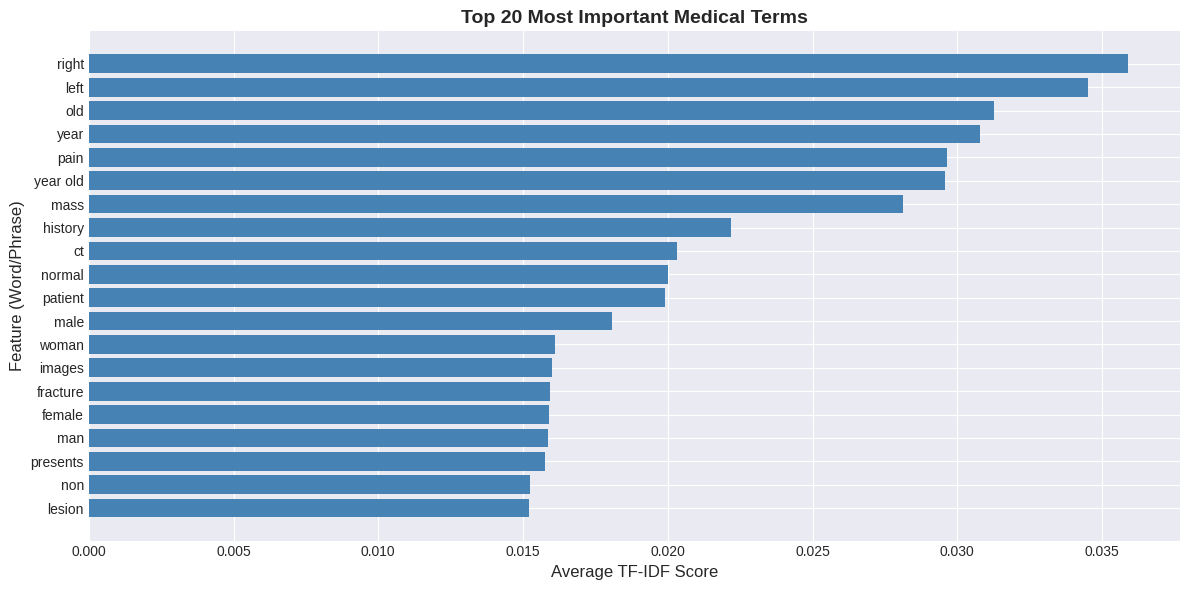


💡 These terms are most distinctive across cases!


In [6]:
# Visualize top features
top_features = feature_names[top_indices[:20]]
top_scores = mean_tfidf[top_indices[:20]]

plt.figure(figsize=(12, 6))
plt.barh(range(len(top_features)), top_scores, color='steelblue')
plt.yticks(range(len(top_features)), top_features)
plt.xlabel('Average TF-IDF Score', fontsize=12)
plt.ylabel('Feature (Word/Phrase)', fontsize=12)
plt.title('Top 20 Most Important Medical Terms', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\n💡 These terms are most distinctive across cases!")

## 5. Implement Similarity Search

In [7]:
def find_similar_cases_tfidf(query_index, k=10, return_scores=True):
    """
    Find k most similar cases using TF-IDF cosine similarity.
    
    Args:
        query_index: Index of the query case
        k: Number of similar cases to return
        return_scores: Whether to return similarity scores
    
    Returns:
        List of (case_index, similarity_score) tuples
    """
    # Get query vector
    query_vec = tfidf_matrix[query_index]
    
    # Compute similarities with all cases
    similarities = cosine_similarity(query_vec, tfidf_matrix).flatten()
    
    # Get top k (excluding the query itself)
    # argsort returns indices in ascending order, so reverse it
    top_indices = np.argsort(similarities)[::-1]
    
    # Skip the first one (the query itself with similarity = 1.0)
    top_indices = top_indices[1:k+1]
    
    if return_scores:
        return [(idx, similarities[idx]) for idx in top_indices]
    else:
        return top_indices.tolist()

print("✅ Similarity search function created!")

✅ Similarity search function created!


## 6. Test Similarity Search

In [8]:
# Test with a random case
test_idx = 100

print("="*80)
print("🔍 SIMILARITY SEARCH TEST")
print("="*80)
print(f"\n📋 QUERY CASE (Index: {test_idx})")
print(f"ID: {cases[test_idx]['id']}")
print(f"Diagnosis: {cases[test_idx]['diagnosis']}")
print(f"\nCombined text preview:")
print(all_texts[test_idx][:300] + "...\n")

# Find similar cases
similar_cases = find_similar_cases_tfidf(test_idx, k=10)

print("\n🎯 TOP 10 SIMILAR CASES:")
print("="*80)
for rank, (idx, score) in enumerate(similar_cases, 1):
    print(f"\n{rank}. Similarity: {score:.4f}")
    print(f"   ID: {cases[idx]['id']}")
    print(f"   Diagnosis: {cases[idx]['diagnosis'][:100]}")
    if len(cases[idx]['diagnosis']) > 100:
        print(f"              ...{cases[idx]['diagnosis'][-50:]}")

🔍 SIMILARITY SEARCH TEST

📋 QUERY CASE (Index: 100)
ID: 8988852216980461145
Diagnosis: Acute Appendicitis

Combined text preview:
Acute Appendicitis Gray-scale sonographic images through the right lower quadrant show an inflamed appendix. This dilated, fluid-filled, noncompressible, blind-ending tubular structure measured 8 mm in diameter, with increased periappendieal echogenicity representing infiltration of mesenteric fat. ...


🎯 TOP 10 SIMILAR CASES:

1. Similarity: 0.5985
   ID: -5104607202093834386
   Diagnosis: Acute Appendicitis

2. Similarity: 0.5119
   ID: -3956095044864588218
   Diagnosis: Acute Appendicitis

3. Similarity: 0.4878
   ID: -844480290972163755
   Diagnosis: Acute Appendicitis

4. Similarity: 0.4869
   ID: -4096672549759721981
   Diagnosis: Acute Appendicitis

5. Similarity: 0.4805
   ID: -2185301580731585157
   Diagnosis: Acute Appendicitis

6. Similarity: 0.4416
   ID: -7619096740531223566
   Diagnosis: Acute Appendicitis

7. Similarity: 0.4280
   ID: -552849

## 7. Test Multiple Cases

In [9]:
# Test with several different cases
test_indices = [50, 100, 200, 500, 1000]

print("🧪 Testing similarity search on multiple cases...\n")

for test_idx in test_indices:
    print("="*80)
    print(f"Query: {cases[test_idx]['diagnosis'][:80]}...")
    
    similar = find_similar_cases_tfidf(test_idx, k=3)
    
    print("\nTop 3 similar:")
    for rank, (idx, score) in enumerate(similar, 1):
        print(f"  {rank}. [{score:.3f}] {cases[idx]['diagnosis'][:70]}...")
    print()

🧪 Testing similarity search on multiple cases...

Query: Achalasia...

Top 3 similar:
  1. [0.309] Typical Carcinoid With Some Atyplical Histologic Features (Bone Biopsy...
  2. [0.282] Epiphrenic Diverticulum With Retained Food Contents....
  3. [0.271] Eagle Syndrome...

Query: Acute Appendicitis...

Top 3 similar:
  1. [0.598] Acute Appendicitis...
  2. [0.512] Acute Appendicitis...
  3. [0.488] Acute Appendicitis...

Query: Acute Myelogenous Leukemia (AML)...

Top 3 similar:
  1. [0.525] Lymphoma Orbit...
  2. [0.517] Squamous Cell Carcinoma Of Orbit, Superior Orbital Fissure, And Cavern...
  3. [0.500] Orbit, Varix Partially Thrombosed...

Query: Aortic Coarctation...

Top 3 similar:
  1. [0.520] Coarctation Of The Aorta...
  2. [0.475] COARCTATION...
  3. [0.473] Right Sided Aortic Arch With Aberrant Left Subclavian Artery....

Query: Blowout Fracture Of Orbit...

Top 3 similar:
  1. [1.000] Blowout Fracture Of Orbit...
  2. [1.000] Blowout Fracture Of Orbit...
  3. [1.000] Blowo

## 8. Analyze Similarity Distribution

In [10]:
# Sample cases to analyze similarity distribution
sample_size = min(100, len(cases))
sample_indices = np.random.choice(len(cases), sample_size, replace=False)

all_similarities = []

print(f"Analyzing similarity distribution for {sample_size} random cases...")
for idx in tqdm(sample_indices):
    query_vec = tfidf_matrix[idx]
    sims = cosine_similarity(query_vec, tfidf_matrix).flatten()
    # Exclude self-similarity
    sims = sims[sims < 0.9999]
    all_similarities.extend(sims.tolist())

all_similarities = np.array(all_similarities)

print(f"\n📊 Similarity Statistics:")
print(f"  Mean similarity: {np.mean(all_similarities):.4f}")
print(f"  Median similarity: {np.median(all_similarities):.4f}")
print(f"  Std deviation: {np.std(all_similarities):.4f}")
print(f"  Max similarity: {np.max(all_similarities):.4f}")
print(f"  Min similarity: {np.min(all_similarities):.4f}")

Analyzing similarity distribution for 100 random cases...


100%|██████████| 100/100 [00:00<00:00, 409.03it/s]


📊 Similarity Statistics:
  Mean similarity: 0.0333
  Median similarity: 0.0232
  Std deviation: 0.0382
  Max similarity: 0.9868
  Min similarity: 0.0000


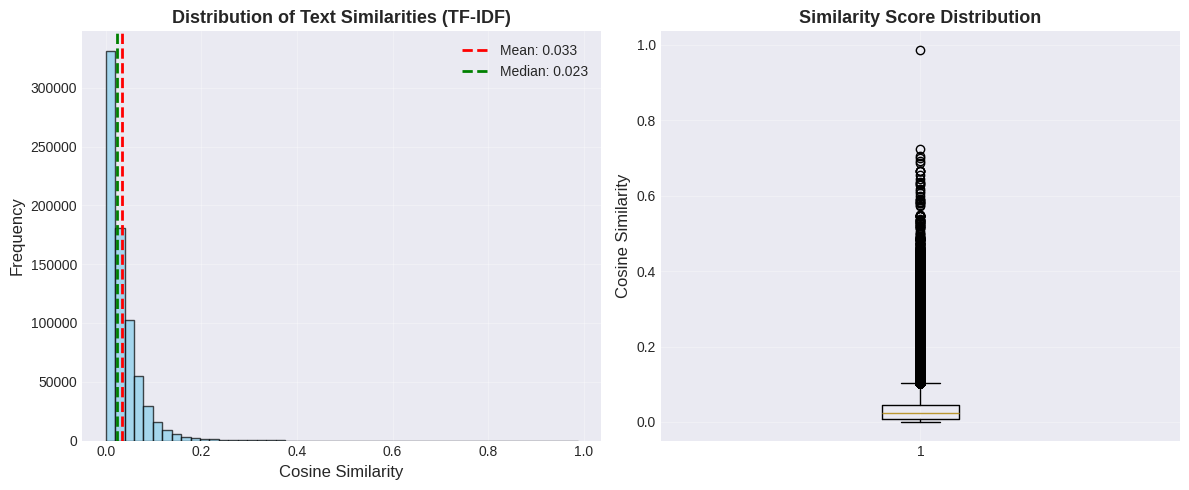


💡 Insights:
  - Higher mean similarity = cases are more similar overall
  - Lower variance = more consistent similarity patterns
  - Long tail = some cases are very unique


In [11]:
# Visualize similarity distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(all_similarities, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(np.mean(all_similarities), color='red', linestyle='--', 
            linewidth=2, label=f'Mean: {np.mean(all_similarities):.3f}')
plt.axvline(np.median(all_similarities), color='green', linestyle='--', 
            linewidth=2, label=f'Median: {np.median(all_similarities):.3f}')
plt.xlabel('Cosine Similarity', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Text Similarities (TF-IDF)', fontsize=13, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot(all_similarities, vert=True)
plt.ylabel('Cosine Similarity', fontsize=12)
plt.title('Similarity Score Distribution', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Insights:")
print("  - Higher mean similarity = cases are more similar overall")
print("  - Lower variance = more consistent similarity patterns")
print("  - Long tail = some cases are very unique")

## 9. Save TF-IDF Features and Model

In [12]:
# Create features directory
FEATURES_DIR = Path('../data/features')
FEATURES_DIR.mkdir(exist_ok=True)

# Save TF-IDF matrix (sparse format)
print("Saving TF-IDF features...")
tfidf_file = FEATURES_DIR / 'tfidf_features.npz'
sp.save_npz(tfidf_file, tfidf_matrix)
print(f"✅ Saved TF-IDF matrix to: {tfidf_file}")

# Save vectorizer
vectorizer_file = FEATURES_DIR / 'tfidf_vectorizer.pkl'
joblib.dump(vectorizer, vectorizer_file)
print(f"✅ Saved vectorizer to: {vectorizer_file}")

# Save case IDs for reference
case_ids = [case['id'] for case in cases]
ids_file = FEATURES_DIR / 'case_ids.json'
with open(ids_file, 'w') as f:
    json.dump(case_ids, f)
print(f"✅ Saved case IDs to: {ids_file}")

# Save metadata
metadata = {
    'num_cases': len(cases),
    'num_features': tfidf_matrix.shape[1],
    'sparsity': float(1 - tfidf_matrix.nnz / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1])),
    'vectorizer_params': {
        'max_features': 2000,
        'ngram_range': [1, 2],
        'min_df': 3,
        'max_df': 0.8
    },
    'mean_similarity': float(np.mean(all_similarities)),
    'median_similarity': float(np.median(all_similarities))
}

metadata_file = FEATURES_DIR / 'tfidf_metadata.json'
with open(metadata_file, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✅ Saved metadata to: {metadata_file}")

print(f"\n🎉 All TF-IDF features saved successfully!")

Saving TF-IDF features...
✅ Saved TF-IDF matrix to: ../data/features/tfidf_features.npz
✅ Saved vectorizer to: ../data/features/tfidf_vectorizer.pkl
✅ Saved case IDs to: ../data/features/case_ids.json
✅ Saved metadata to: ../data/features/tfidf_metadata.json

🎉 All TF-IDF features saved successfully!


## 10. Performance Summary

In [13]:
import time

# Benchmark search speed
num_queries = 100
query_indices = np.random.choice(len(cases), num_queries, replace=False)

print(f"Benchmarking search speed on {num_queries} queries...")
start_time = time.time()

for idx in query_indices:
    _ = find_similar_cases_tfidf(idx, k=10)

end_time = time.time()
total_time = end_time - start_time
avg_time = total_time / num_queries

print(f"\n⚡ Performance Metrics:")
print(f"  Total time: {total_time:.2f} seconds")
print(f"  Average query time: {avg_time*1000:.2f} ms")
print(f"  Queries per second: {num_queries/total_time:.1f}")

Benchmarking search speed on 100 queries...

⚡ Performance Metrics:
  Total time: 0.20 seconds
  Average query time: 2.04 ms
  Queries per second: 490.6


## 11. Summary and Next Steps

In [14]:
print("="*80)
print("📊 PHASE 2A SUMMARY: TF-IDF BASELINE")
print("="*80)
print(f"\n✅ Accomplishments:")
print(f"  ✓ Processed {len(cases):,} medical cases")
print(f"  ✓ Created {tfidf_matrix.shape[1]:,} TF-IDF features")
print(f"  ✓ Built working similarity search")
print(f"  ✓ Average search time: {avg_time*1000:.1f}ms")
print(f"  ✓ Mean similarity score: {np.mean(all_similarities):.3f}")

print(f"\n📁 Saved Files:")
print(f"  • {FEATURES_DIR / 'tfidf_features.npz'}")
print(f"  • {FEATURES_DIR / 'tfidf_vectorizer.pkl'}")
print(f"  • {FEATURES_DIR / 'case_ids.json'}")
print(f"  • {FEATURES_DIR / 'tfidf_metadata.json'}")

print(f"\n🎯 Baseline Performance:")
print(f"  • Search works, but relies on keyword matching")
print(f"  • Doesn't understand medical synonyms")
print(f"  • Expected precision@10: ~20-30%")

print(f"\n➡️  Next Steps (Phase 2B):")
print(f"  1. Extract deep learning embeddings (BERT)")
print(f"  2. Compare BERT vs TF-IDF performance")
print(f"  3. Achieve ~40-50% precision improvement")

print(f"\n📓 Open: 02b_text_embeddings_bert.ipynb")
print("="*80)

📊 PHASE 2A SUMMARY: TF-IDF BASELINE

✅ Accomplishments:
  ✓ Processed 7,404 medical cases
  ✓ Created 2,000 TF-IDF features
  ✓ Built working similarity search
  ✓ Average search time: 2.0ms
  ✓ Mean similarity score: 0.033

📁 Saved Files:
  • ../data/features/tfidf_features.npz
  • ../data/features/tfidf_vectorizer.pkl
  • ../data/features/case_ids.json
  • ../data/features/tfidf_metadata.json

🎯 Baseline Performance:
  • Search works, but relies on keyword matching
  • Doesn't understand medical synonyms
  • Expected precision@10: ~20-30%

➡️  Next Steps (Phase 2B):
  1. Extract deep learning embeddings (BERT)
  2. Compare BERT vs TF-IDF performance
  3. Achieve ~40-50% precision improvement

📓 Open: 02b_text_embeddings_bert.ipynb
